# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice, i.e. a total of 5 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



## Setup

In [1]:
import pandas as pd
import sklearn as sk

alldata = pd.read_excel('alldata.xlsx')
drdata = pd.read_excel('drdata.xlsx')
drqdata = pd.read_excel('drq.xlsx')

tv2data = pd.read_excel('tv2data.xlsx')
tv2qdata = pd.read_excel('tv2q.xlsx')

electedData = pd.read_excel('electeddata.xlsx')

### 1. Age of the candidates grouped on parties

In [2]:
filtered_data = alldata[['parti', 'alder']].copy()

filtered_data['age_group'] = pd.cut(
    filtered_data['alder'],
    bins=[0, 30, 40, 50, 60, 70, 80],
    labels=['0-30', '31-40', '41-50', '51-60', '61-70', '71+']
)

age_group_analysis = filtered_data.groupby(['parti', 'age_group'], observed=False).size().unstack(fill_value=0)
age_group_analysis['mean_age'] = filtered_data.groupby('parti')['alder'].mean().round(2)
age_group_analysis['total_candidates'] = filtered_data.groupby('parti').size()

display(age_group_analysis)



age_group,0-30,31-40,41-50,51-60,61-70,71+,mean_age,total_candidates
parti,,,,,,,,
Alternativet,10,7,23,14,8,3,46.00,67
Danmarksdemokraterne,2,5,11,12,7,0,51.22,37
Dansk Folkeparti,7,7,16,15,3,1,45.53,49
Det Konservative Folkeparti,15,14,26,34,5,0,42.90,98
Enhedslisten,17,18,14,12,7,3,40.51,74
"Frie Grønne, Danmarks Nye Venstrefløjsparti",9,11,3,2,1,0,34.81,26
Kristendemokraterne,4,4,13,9,10,1,49.02,42
Liberal Alliance,21,18,16,8,4,1,36.89,70
Løsgænger,0,1,1,1,0,0,48.00,3


<Axes: xlabel='alder', ylabel='parti'>

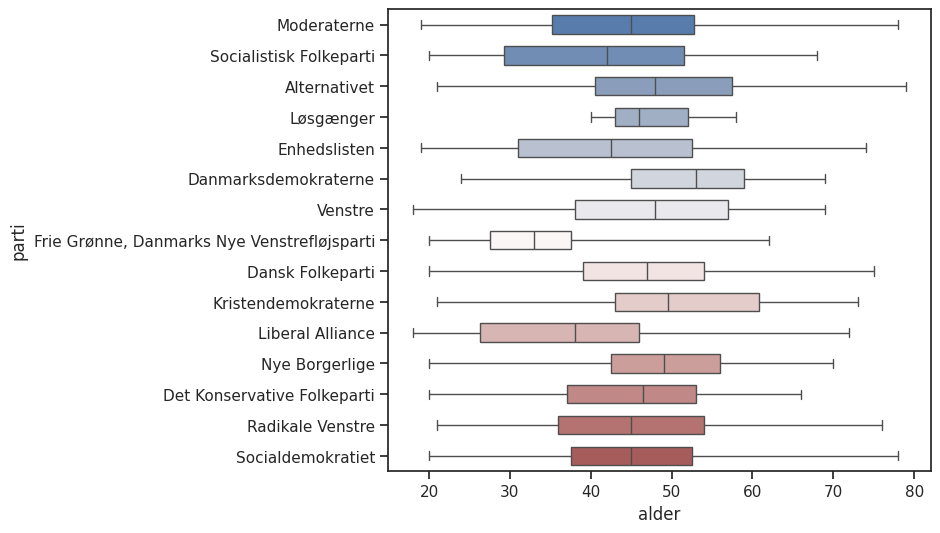

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

data = alldata[['parti', 'alder']]
data = data.dropna()
# Replace ages of 0 with the median age
median_age = data[data['alder'] > 0]['alder'].median()
data['alder'] = data['alder'].replace(0, median_age)

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x='alder', y='parti', data=data, whis=[0, 100], width=.6, hue='parti', palette="vlag", legend=False)


### An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.


In [107]:
confident_data = alldata[['parti', 'navn']]
confident_data = confident_data.dropna()
confident_data

cleaned_data = alldata.drop(columns=['parti', 'navn', 'alder'])


confident_data['confident_responses'] = cleaned_data.apply(lambda row: (row == 2).sum() + (row == -2).sum(), axis=1)
confident_data.sort_values('confident_responses', ascending=False).head(10)



,parti,navn,confident_responses
505,Enhedslisten,Sarah Nørris,49
88,Det Konservative Folkeparti,Søren Vanting,49
559,Nye Borgerlige,Kim Andkjær Doberck,44
44,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Mohamed Abdikarim,43
152,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Rashid Ali,43
503,Enhedslisten,Jan Filbært,42
437,Dansk Folkeparti,Lone Vase Langballe,42
284,Nye Borgerlige,John Bjerg,42
359,Dansk Folkeparti,Frank Sørensen,42
151,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Elise Bjerkrheim,42
